In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, minmax_scale

from main_event import prepare_event_data, prepare_json_event_data
from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_velocity_acceleration_direction,
    calculate_player_ball_distances,
    get_n_smallest_indices_sorted,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [5]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


## Tracking for individual Players Visualization

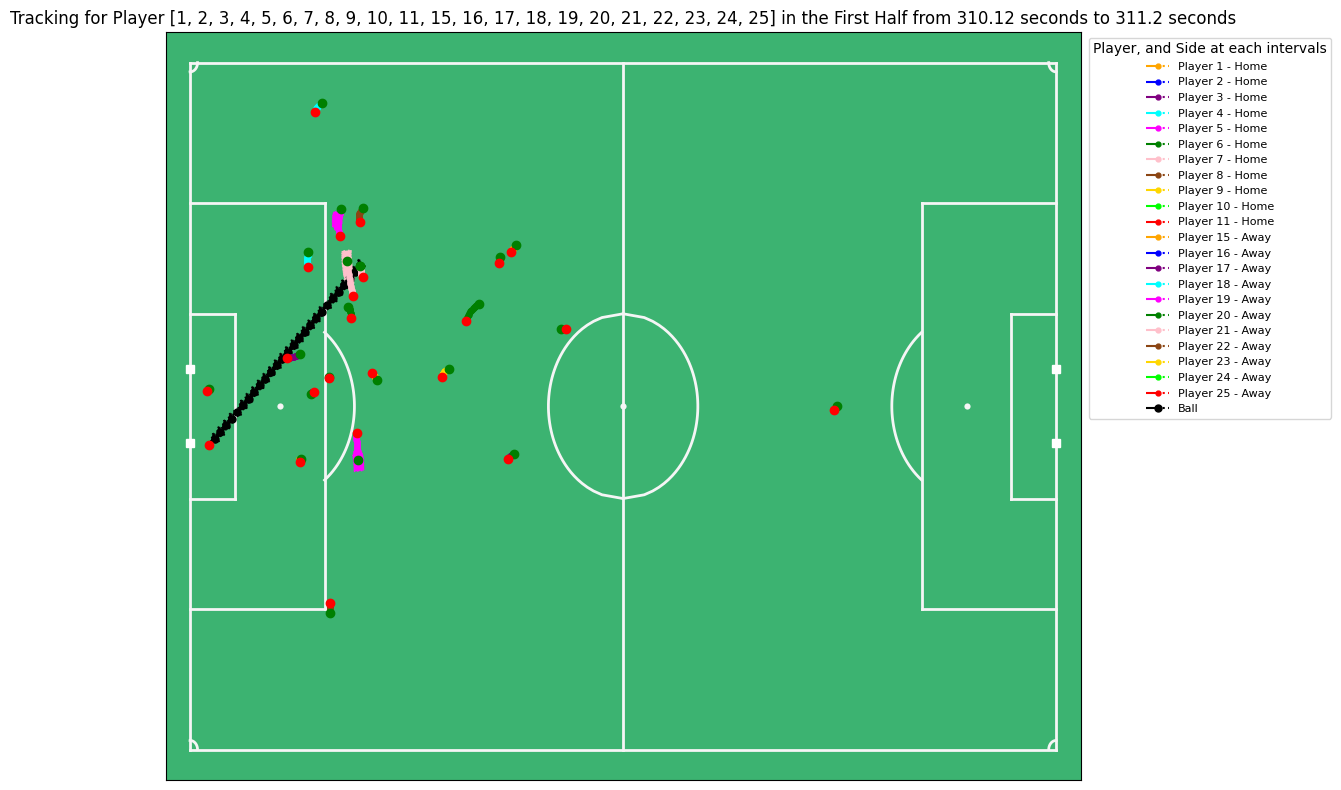

In [6]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
# [2289:2307][5923:5953]
game_2_pre.player_visualization(game_1_data.loc[7753:7780], players=players, sides=sides, plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [7]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [8]:
vel_acc_game_1_data = calculate_velocity_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_direction(game_2_data)

In [9]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00035,0.0,0.0004,306.869898,0.0,85.741154,0.0,119.054604,0.0,290.88898
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00039,0.0,0.000278,307.694240,0.0,85.741154,0.0,119.054604,0.0,290.88898
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00028,0.0,0.000665,282.154942,0.0,85.741154,0.0,119.054604,0.0,290.88898
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00037,0.0,0.000361,56.309932,0.0,85.741154,0.0,119.054604,0.0,290.88898


In [10]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [11]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00035,0.0,0.0004,306.869898,0.0,85.741154,0.0,119.054604,0.0,290.88898
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00039,0.0,0.000278,307.694240,0.0,85.741154,0.0,119.054604,0.0,290.88898
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00028,0.0,0.000665,282.154942,0.0,85.741154,0.0,119.054604,0.0,290.88898
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00037,0.0,0.000361,56.309932,0.0,85.741154,0.0,119.054604,0.0,290.88898


In [ ]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [ ]:
game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [12]:
game_1_player_data = game_1_ply_tra.copy()
game_2_player_data = game_2_ply_tra.copy()

# Classification

In [13]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)

In [14]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [15]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [16]:
valid_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[valid_indices]
y_1 = game_1_event.loc[valid_indices]

In [17]:
valid_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[valid_indices]
y_2 = game_2_event.loc[valid_indices]

In [18]:
X_2

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
146,0.92146,0.49193,0.66669,0.25888,0.68402,0.40418,0.65595,0.55007,0.65875,0.79306,...,0.001001,338.304891,0.001134,4.553768,0.001365,354.957549,0.000595,310.914383,0.000569,293.860175
147,0.92105,0.49184,0.66734,0.25738,0.68413,0.40344,0.65592,0.54961,0.65911,0.79202,...,0.000992,338.091295,0.001083,4.236395,0.001355,354.920392,0.00071,302.347443,0.007129,275.150769
148,0.92065,0.49174,0.66796,0.25587,0.68424,0.40257,0.65590,0.54908,0.65947,0.79090,...,0.000961,341.188111,0.001044,4.945967,0.001356,354.499589,0.000716,303.023868,0.006945,273.715289
149,0.92021,0.49171,0.66856,0.25436,0.68433,0.40168,0.65585,0.54861,0.65982,0.78977,...,0.00093,341.175290,0.001014,5.092115,0.001352,352.349349,0.000757,299.275254,0.006955,273.709951
150,0.91975,0.49171,0.66915,0.25276,0.68442,0.40080,0.65580,0.54814,0.66015,0.78859,...,0.000979,332.650124,0.000954,5.411869,0.001361,349.845733,0.000899,295.709954,0.006945,273.715289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00035,0.000000,0.0004,306.869898,0.0,85.741154,0.0,119.054604,0.0,290.888980
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00039,0.000000,0.000278,307.694240,0.0,85.741154,0.0,119.054604,0.0,290.888980
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00028,0.000000,0.000665,282.154942,0.0,85.741154,0.0,119.054604,0.0,290.888980
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00037,0.000000,0.000361,56.309932,0.0,85.741154,0.0,119.054604,0.0,290.888980


# New Dataset

In [19]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [21]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


In [22]:
vel_acc_game_3_data = calculate_velocity_direction(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.002322,252.969843,0.005266,260.931211,0.000180,236.309932,0.000304,170.537678,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.000457,241.189206,0.000970,269.409343,0.000430,35.537678,0.000224,153.434949,0.0,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.000150,216.869898,0.001427,264.369317,0.000567,40.710847,0.000963,257.406670,0.0,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.000679,256.373005,0.000202,278.530766,0.000497,25.016893,0.000391,256.675469,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.000660,178.264295,0.000490,249.717441,0.000273,246.250506,0.000676,150.780753,0.0,300.963757
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.000934,164.475889,0.000574,228.532295,0.000546,98.426969,0.001117,135.725224,0.0,300.963757
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.001417,147.094757,0.000777,214.508523,0.000864,118.345694,0.001424,155.955777,0.0,300.963757
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.001431,182.002533,0.001058,143.455028,0.001463,115.513870,0.001392,172.568592,0.0,300.963757


In [23]:
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:]
game_3_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.002322,252.969843,0.005266,260.931211,0.000180,236.309932,0.000304,170.537678,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.000457,241.189206,0.000970,269.409343,0.000430,35.537678,0.000224,153.434949,0.0,NaN
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.000150,216.869898,0.001427,264.369317,0.000567,40.710847,0.000963,257.406670,0.0,NaN
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.000679,256.373005,0.000202,278.530766,0.000497,25.016893,0.000391,256.675469,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.000660,178.264295,0.000490,249.717441,0.000273,246.250506,0.000676,150.780753,0.0,300.963757
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.000934,164.475889,0.000574,228.532295,0.000546,98.426969,0.001117,135.725224,0.0,300.963757
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.001417,147.094757,0.000777,214.508523,0.000864,118.345694,0.001424,155.955777,0.0,300.963757
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.001431,182.002533,0.001058,143.455028,0.001463,115.513870,0.001392,172.568592,0.0,300.963757


In [ ]:
game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").round(4).fillna(0)

In [24]:
game_3_player_data = game_3_ply_tra.copy()
game_3_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.002322,252.969843,0.005266,260.931211,0.000180,236.309932,0.000304,170.537678,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.000457,241.189206,0.000970,269.409343,0.000430,35.537678,0.000224,153.434949,0.0,NaN
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.000150,216.869898,0.001427,264.369317,0.000567,40.710847,0.000963,257.406670,0.0,NaN
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.000679,256.373005,0.000202,278.530766,0.000497,25.016893,0.000391,256.675469,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.000660,178.264295,0.000490,249.717441,0.000273,246.250506,0.000676,150.780753,0.0,300.963757
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.000934,164.475889,0.000574,228.532295,0.000546,98.426969,0.001117,135.725224,0.0,300.963757
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.001417,147.094757,0.000777,214.508523,0.000864,118.345694,0.001424,155.955777,0.0,300.963757
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.001431,182.002533,0.001058,143.455028,0.001463,115.513870,0.001392,172.568592,0.0,300.963757


In [25]:
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [26]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [27]:
valid_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[valid_indices]
y_3 = game_3_event.loc[valid_indices]

assert X_3.shape[0] == y_3.shape[0]

In [28]:
X_3

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction
384,0.84896,0.50882,0.63285,0.18320,0.73758,0.39566,0.71792,0.66465,0.55429,0.91139,...,0.000546,333.904576,0.000524,325.097504,0.001387,321.146626,0.000930,26.840510,0.000424,235.561011
385,0.84939,0.50864,0.63267,0.18279,0.73773,0.39606,0.71791,0.66512,0.55430,0.91192,...,0.000533,336.801409,0.000561,320.063617,0.001404,324.272602,0.000953,28.178590,0.002341,46.557508
386,0.84987,0.50834,0.63248,0.18255,0.73789,0.39654,0.71791,0.66555,0.55430,0.91241,...,0.000531,340.201124,0.000546,325.437475,0.001437,325.203974,0.000944,24.393739,0.004771,47.548575
387,0.85034,0.50816,0.63230,0.18221,0.73806,0.39692,0.71791,0.66600,0.55430,0.91292,...,0.000557,342.216112,0.000589,319.820766,0.001481,325.451633,0.000976,24.200972,0.004764,47.637317
388,0.85080,0.50799,0.63211,0.18188,0.73820,0.39735,0.71787,0.66652,0.55428,0.91342,...,0.000538,341.565051,0.000637,312.455196,0.001509,327.994617,0.001007,24.020247,0.004763,47.467385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.11993,0.51783,0.42811,0.48741,0.43863,0.79777,0.43239,0.63392,0.43707,0.32970,...,0.000472,4.864514,0.000347,303.231711,0.000320,14.470294,0.001318,324.260222,0.006087,296.649248
143530,0.11993,0.51783,0.42872,0.48704,0.43895,0.79718,0.43311,0.63370,0.43740,0.32903,...,0.000496,350.727398,0.000344,305.537678,0.000330,14.036243,0.001304,325.944220,0.006082,296.565051
143531,0.11993,0.51783,0.42932,0.48660,0.43928,0.79654,0.43382,0.63342,0.43772,0.32837,...,0.000503,342.645975,0.000312,309.805571,0.000335,17.354025,0.001386,323.212780,0.006087,296.649248
143532,0.11993,0.51783,0.42993,0.48618,0.43961,0.79595,0.43452,0.63314,0.43802,0.32764,...,0.000490,343.412661,0.000341,301.827447,0.000321,5.355825,0.001379,325.042024,0.006087,296.649248


### Adding which team has the ball using distance metrics

In [29]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[X_1.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[X_1.index, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[X_1.index, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[X_2.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[X_2.index, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[X_2.index, "P_11_velocity":]
game_3_players, game_3_ball, game_3_vel_acc = vel_acc_game_3_data.loc[X_3.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_3_data.loc[X_3.index, "Ball-x":"Ball-y"], vel_acc_game_3_data.loc[X_3.index, "P_11_velocity":]

In [30]:
game_1_result = calculate_player_ball_distances(
    game_data=game_1_data.loc[X_1.index],
    player_data=game_1_players,
    ball_data=game_1_ball
)
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
6,0.24,0.563151,0.349641,0.242261,0.249360,0.295297,0.365688,0.166072,0.177541,0.208422,...,0.179660,0.142050,0.393339,0.269474,0.102840,0.287690,0.043790,0.558136,0.361370,0.213209
7,0.28,0.567758,0.362466,0.250968,0.248928,0.287334,0.380255,0.176221,0.173689,0.196685,...,0.162456,0.149593,0.408004,0.282869,0.105487,0.302437,0.059987,0.574458,0.347387,0.207090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,5744.56,0.804350,0.185293,0.427381,0.428353,0.056973,0.095513,0.184103,0.519533,0.082591,...,0.114894,0.030264,0.086602,0.363107,0.154489,0.155523,0.009879,0.381254,0.393613,0.225027
143615,5744.60,0.806604,0.186092,0.428208,0.430656,0.060635,0.092409,0.186681,0.518725,0.080450,...,0.116965,0.026288,0.089510,0.362792,0.151052,0.156188,0.015445,0.378841,0.394586,0.225026
143616,5744.64,0.808892,0.187006,0.429086,0.432985,0.064416,0.090174,0.189370,0.517919,0.078450,...,0.119181,0.023143,0.092503,0.362527,0.147764,0.156886,0.021004,0.376427,0.395626,0.225129
143617,5744.68,0.811206,0.188044,0.430041,0.435382,0.068212,0.090508,0.192103,0.517189,0.076664,...,0.121536,0.021172,0.095605,0.362424,0.144597,0.157611,0.026631,0.374041,0.396738,0.225333


In [31]:
game_2_result = calculate_player_ball_distances(
    game_data=game_2_data.loc[X_2.index],
    player_data=game_2_players,
    ball_data=game_2_ball
)
game_2_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
146,5.84,0.496703,0.342948,0.277024,0.236026,0.373352,0.313091,0.180737,0.153203,0.257618,...,0.300610,0.114074,0.135304,0.244139,0.380443,0.000552,0.156475,0.510173,0.154591,0.171414
147,5.88,0.495560,0.339008,0.274342,0.236814,0.377921,0.307608,0.177571,0.154230,0.262085,...,0.306740,0.118177,0.130822,0.238153,0.385671,0.006124,0.150416,0.503450,0.156447,0.167461
148,5.92,0.494714,0.335354,0.272058,0.237919,0.382450,0.302357,0.174755,0.155649,0.266488,...,0.312700,0.122323,0.126521,0.232338,0.390834,0.012529,0.144592,0.496938,0.158735,0.163931
149,5.96,0.493924,0.331728,0.269874,0.239181,0.387007,0.297109,0.172067,0.157306,0.270939,...,0.318660,0.126717,0.122443,0.226515,0.396016,0.019004,0.138811,0.490421,0.161263,0.160582
150,6.00,0.493213,0.328212,0.267811,0.240609,0.391537,0.291942,0.169492,0.159178,0.275354,...,0.324600,0.131340,0.118528,0.220701,0.401187,0.025408,0.133247,0.483911,0.164015,0.157506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603386,0.602958,0.989591,...,0.081458,0.493244,0.641833,0.649969,0.583007,0.450188,1.090450,0.456393,0.672318,0.169162
141153,5646.12,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603189,0.602958,0.990306,...,0.081458,0.492950,0.642163,0.649860,0.583427,0.450188,1.090471,0.456189,0.672318,0.169162
141154,5646.16,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.602523,0.602958,0.991150,...,0.081458,0.492180,0.642544,0.650310,0.583837,0.450188,1.090486,0.455554,0.672318,0.169162
141155,5646.20,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.601309,0.602958,0.991955,...,0.081458,0.489952,0.642961,0.650757,0.584248,0.450188,1.090506,0.455871,0.672318,0.169162


In [32]:
game_3_result = calculate_player_ball_distances(
    game_data=game_3_data.loc[X_3.index],
    player_data=game_3_players,
    ball_data=game_3_ball
)
game_3_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
384,15.36,0.352504,0.331159,0.256519,0.284357,0.429872,0.378481,0.119092,0.000400,0.180356,...,0.346157,0.223549,0.211809,0.328314,0.132664,0.086096,0.074542,0.142414,0.148002,0.117704
385,15.40,0.351206,0.332361,0.255612,0.282324,0.428503,0.380764,0.117909,0.003158,0.178264,...,0.345420,0.223845,0.213747,0.330944,0.131090,0.085358,0.075985,0.144785,0.145465,0.118950
386,15.44,0.348255,0.334462,0.253864,0.277877,0.425091,0.384800,0.115926,0.008345,0.173728,...,0.343813,0.224480,0.217718,0.335997,0.128306,0.084851,0.079418,0.149504,0.141060,0.122100
387,15.48,0.345348,0.336726,0.252235,0.273450,0.421719,0.388662,0.114108,0.013467,0.169228,...,0.342284,0.225251,0.221681,0.341090,0.125653,0.084581,0.082921,0.154277,0.136661,0.125282
388,15.52,0.342459,0.339027,0.250612,0.269035,0.418362,0.392650,0.112378,0.018609,0.164744,...,0.340763,0.226084,0.225644,0.346147,0.123156,0.084541,0.086549,0.159133,0.132340,0.128482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,5741.16,0.757354,0.451340,0.512179,0.456022,0.484797,0.294182,0.351505,0.283820,0.373873,...,0.629015,0.075225,0.365217,0.600645,0.393664,0.412268,0.252676,0.422322,0.467580,0.351770
143530,5741.20,0.759984,0.452956,0.516748,0.459150,0.484995,0.298928,0.355475,0.285778,0.371533,...,0.626339,0.076360,0.370834,0.606412,0.397196,0.412906,0.256383,0.427348,0.470827,0.347940
143531,5741.24,0.762663,0.454658,0.521307,0.462330,0.485265,0.303622,0.359477,0.287854,0.369232,...,0.623813,0.077862,0.376445,0.612175,0.400782,0.413675,0.260164,0.432423,0.474142,0.344226
143532,5741.28,0.765381,0.456408,0.525908,0.465563,0.485640,0.308268,0.363557,0.290019,0.367110,...,0.621293,0.079760,0.382045,0.617958,0.404413,0.414503,0.264029,0.437502,0.477498,0.340496


In [33]:
game_1_closest_to_ball = get_n_smallest_indices_sorted(game_1_result.iloc[:, 1:], 1)
game_2_closest_to_ball = get_n_smallest_indices_sorted(game_2_result.iloc[:, 1:], 1)
game_3_closest_to_ball = get_n_smallest_indices_sorted(game_3_result.iloc[:, 1:], 1)
game_3_closest_to_ball

,P-1
384,Home-Player7
385,Home-Player7
386,Home-Player7
387,Home-Player7
388,Home-Player7
...,...
143529,Away-Player25
143530,Away-Player25
143531,Away-Player25
143532,Away-Player25


In [34]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    return team

In [35]:
X_1["Team"] = add_ball_with(game_1_closest_to_ball)
X_2["Team"] = add_ball_with(game_2_closest_to_ball)
X_3["Team"] = add_ball_with(game_3_closest_to_ball)

In [36]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.044926,25.019205,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,99.039483,0.000765,115.559965,0.000608,143.695503,0.001184,130.548826,0.016621,348.723870,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,183.366461,0.000462,111.571307,0.000884,223.625165,0.001164,143.031656,0.016693,275.707178,0.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,230.194429,0.000281,184.085617,0.001201,230.744158,0.001677,129.193273,0.016692,275.673022,0.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,222.594029,0.000552,227.935673,0.001131,224.283840,0.001414,146.534621,0.016692,275.673022,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,142.028396,0.001834,153.434949,0.000902,125.980678,0.001998,168.746295,0.005077,231.075833,1.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,143.444418,0.001804,156.134240,0.000866,126.076012,0.001967,168.861440,0.005084,230.988148,1.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,143.673174,0.001825,153.996654,0.00085,126.869898,0.001946,169.036610,0.005077,231.075833,1.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,142.264811,0.001825,151.890584,0.000924,121.282654,0.001942,169.615979,0.005091,231.058988,1.0


In [48]:
away_cols = X_1.columns.str.startswith("Away")
X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

away_cols = X_2.columns.str.startswith("Away")
X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

away_cols = X_3.columns.str.startswith("Away")
X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [49]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.044926,25.019205,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,99.039483,0.000765,115.559965,0.000608,143.695503,0.001184,130.548826,0.016621,348.723870,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,183.366461,0.000462,111.571307,0.000884,223.625165,0.001164,143.031656,0.016693,275.707178,0.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,230.194429,0.000281,184.085617,0.001201,230.744158,0.001677,129.193273,0.016692,275.673022,0.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,222.594029,0.000552,227.935673,0.001131,224.283840,0.001414,146.534621,0.016692,275.673022,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,142.028396,0.001834,153.434949,0.000902,125.980678,0.001998,168.746295,0.005077,231.075833,1.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,143.444418,0.001804,156.134240,0.000866,126.076012,0.001967,168.861440,0.005084,230.988148,1.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,143.673174,0.001825,153.996654,0.00085,126.869898,0.001946,169.036610,0.005077,231.075833,1.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,142.264811,0.001825,151.890584,0.000924,121.282654,0.001942,169.615979,0.005091,231.058988,1.0


In [170]:
X_1.loc[2289:2307]

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction,Team
2289,0.26861,0.48489,0.92126,0.57802,0.92892,0.51339,0.91952,0.59741,0.63646,0.48125,...,2.134113,0.008162,-0.477345,0.016250,1.819506,0.024906,2.803970,0.325291,1.490782,0.0
2290,0.26861,0.48489,0.92286,0.57752,0.93007,0.51264,0.91913,0.59762,0.63617,0.48149,...,2.173084,0.009169,-0.451453,0.010854,1.826948,0.024698,2.768605,0.198756,1.135841,1.0
2291,0.26861,0.48489,0.92437,0.57694,0.93116,0.51193,0.91870,0.59782,0.63586,0.48175,...,2.062606,0.008610,-0.450661,0.011385,1.725115,0.024981,2.740643,0.153657,0.732452,1.0
2292,0.26861,0.48489,0.92598,0.57624,0.93231,0.51111,0.91822,0.59798,0.63554,0.48198,...,2.074962,0.008310,-0.369334,0.015847,1.681454,0.025056,2.709185,0.154011,0.732574,1.0
2293,0.26861,0.48489,0.92750,0.57556,0.93333,0.51041,0.91773,0.59806,0.63519,0.48217,...,2.122451,0.006731,-0.262995,0.016018,1.617637,0.025269,2.669096,0.153843,0.731366,1.0
2294,0.26860,0.48489,0.92912,0.57484,0.93439,0.50959,0.91718,0.59813,0.63482,0.48238,...,2.074962,0.006828,-0.414507,0.016767,1.526050,0.024152,2.691833,0.153843,0.731366,1.0
2295,0.26858,0.48489,0.93063,0.57414,0.93532,0.50893,0.91662,0.59812,0.63440,0.48259,...,2.158799,0.004279,-0.117109,0.018507,1.543776,0.023380,2.711425,0.153843,0.731366,0.0
2296,0.26856,0.48489,0.93220,0.57338,0.93622,0.50833,0.91601,0.59811,0.63397,0.48282,...,2.137526,0.003750,0.000000,0.020275,1.521454,0.022750,2.746802,0.153843,0.731366,0.0
2297,0.26855,0.48489,0.93367,0.57259,0.93699,0.50786,0.91537,0.59801,0.63353,0.48297,...,2.150799,0.002574,0.507099,0.021263,1.535517,0.022718,2.722251,0.153843,0.731366,0.0
2298,0.26853,0.48489,0.93518,0.57175,0.93775,0.50739,0.91468,0.59791,0.63307,0.48314,...,2.174546,0.002305,0.708626,0.023022,1.527345,0.023970,2.617272,0.153657,0.732452,1.0


In [171]:
X_1.loc[5923:5942]

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_direction,P_22_velocity,P_22_direction,P_23_velocity,P_23_direction,P_24_velocity,P_24_direction,Ball_velocity,Ball_direction,Team
5923,0.13058,0.48106,0.51274,0.68277,0.46961,0.56180,0.46187,0.44686,0.53039,0.25544,...,-0.028564,0.055627,-0.067465,0.027019,0.037020,0.022522,0.044415,0.054583,1.395859,0.0
5924,0.13065,0.48116,0.51393,0.68276,0.46994,0.56141,0.46285,0.44699,0.53112,0.25599,...,-0.033968,0.054896,-0.072930,0.027094,0.083141,0.022419,0.122972,0.116431,1.187898,0.0
5925,0.13070,0.48125,0.51512,0.68276,0.47027,0.56108,0.46379,0.44709,0.53181,0.25654,...,-0.009852,0.054416,-0.078181,0.026844,0.083915,0.022451,0.134023,0.329368,1.013323,0.0
5926,0.13073,0.48127,0.51629,0.68275,0.47060,0.56069,0.46473,0.44714,0.53249,0.25718,...,-0.015305,0.054167,-0.078542,0.026595,0.084703,0.021552,0.069655,0.329580,1.013725,1.0
5927,0.13075,0.48127,0.51747,0.68274,0.47091,0.56035,0.46565,0.44714,0.53315,0.25783,...,0.005263,0.053938,-0.083526,0.026450,0.123183,0.021303,0.070471,0.329448,1.014369,1.0
5928,0.13078,0.48127,0.51863,0.68277,0.47122,0.56002,0.46657,0.44716,0.53376,0.25847,...,0.005405,0.053191,-0.084703,0.025954,0.125550,0.020500,0.000000,0.329368,1.013323,1.0
5929,0.13081,0.48127,0.51977,0.68280,0.47154,0.55974,0.46748,0.44720,0.53437,0.25912,...,0.033137,0.054084,-0.111168,0.025894,0.174672,0.020056,0.074860,0.329580,1.013725,1.0
5930,0.13082,0.48127,0.52091,0.68287,0.47185,0.55950,0.46835,0.44725,0.53495,0.25977,...,0.028241,0.053776,-0.139925,0.025842,0.214472,0.019750,0.000000,0.329580,1.013725,1.0
5931,0.13084,0.48127,0.52203,0.68298,0.47215,0.55927,0.46922,0.44713,0.53552,0.26042,...,-0.017339,0.053069,-0.146561,0.025301,0.209023,0.019252,0.012986,0.329236,1.013968,1.0
5932,0.13086,0.48127,0.52314,0.68309,0.47245,0.55908,0.47008,0.44712,0.53605,0.26108,...,0.017855,0.052653,-0.123766,0.025348,0.259332,0.019002,0.013157,0.329580,1.013725,1.0


In [168]:
y_1[y_1["Type"] == "SHOT"].iloc[19:39]

,Type
5923,SHOT
5924,SHOT
5925,SHOT
5926,SHOT
5927,SHOT
5928,SHOT
5929,SHOT
5930,SHOT
5931,SHOT
5932,SHOT


In [50]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546], dtype=int64))

In [51]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485], dtype=int64))

In [52]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391], dtype=int64))

In [61]:
scaler = MinMaxScaler()
X_1_scaled = X_1.values#pd.concat([X_1.iloc[:, :46], X_1.iloc[:, -3:]], axis=1).values#scaler.fit_transform(X_1)
X_2_scaled = X_2.values#pd.concat([X_2.iloc[:, :46], X_2.iloc[:, -3:]], axis=1).values#scaler.transform(X_2)
X_3_scaled = X_3.values#pd.concat([X_3.iloc[:, :46], X_3.iloc[:, -3:]], axis=1).values#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=0)
# X_2_scaled = minmax_scale(X_2, axis=0)
# X_3_scaled = minmax_scale(X_3, axis=0)

# label_encoder = LabelEncoder()
# y_1_encoded = label_encoder.fit_transform(y_1)
# y_2_encoded = label_encoder.transform(y_2)
# y_3_encoded = label_encoder.transform(y_3)

In [62]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57785, 93)
(56102, 93)
(74014, 93)


In [63]:
X = np.concatenate([X_1_scaled, X_2_scaled])
y = np.concatenate((y_1, y_2)).ravel()

assert X.shape[0] == y.shape[0]

In [64]:
# %load_ext cuml.accel

In [66]:
models = {
      # "AdaBoost classifier": AdaBoostClassifier(), 
      # "Logistic regression": LogisticRegression(solver="saga"),
      "Random forest classifier": RandomForestClassifier(n_jobs=-1, max_depth=15), 
    }

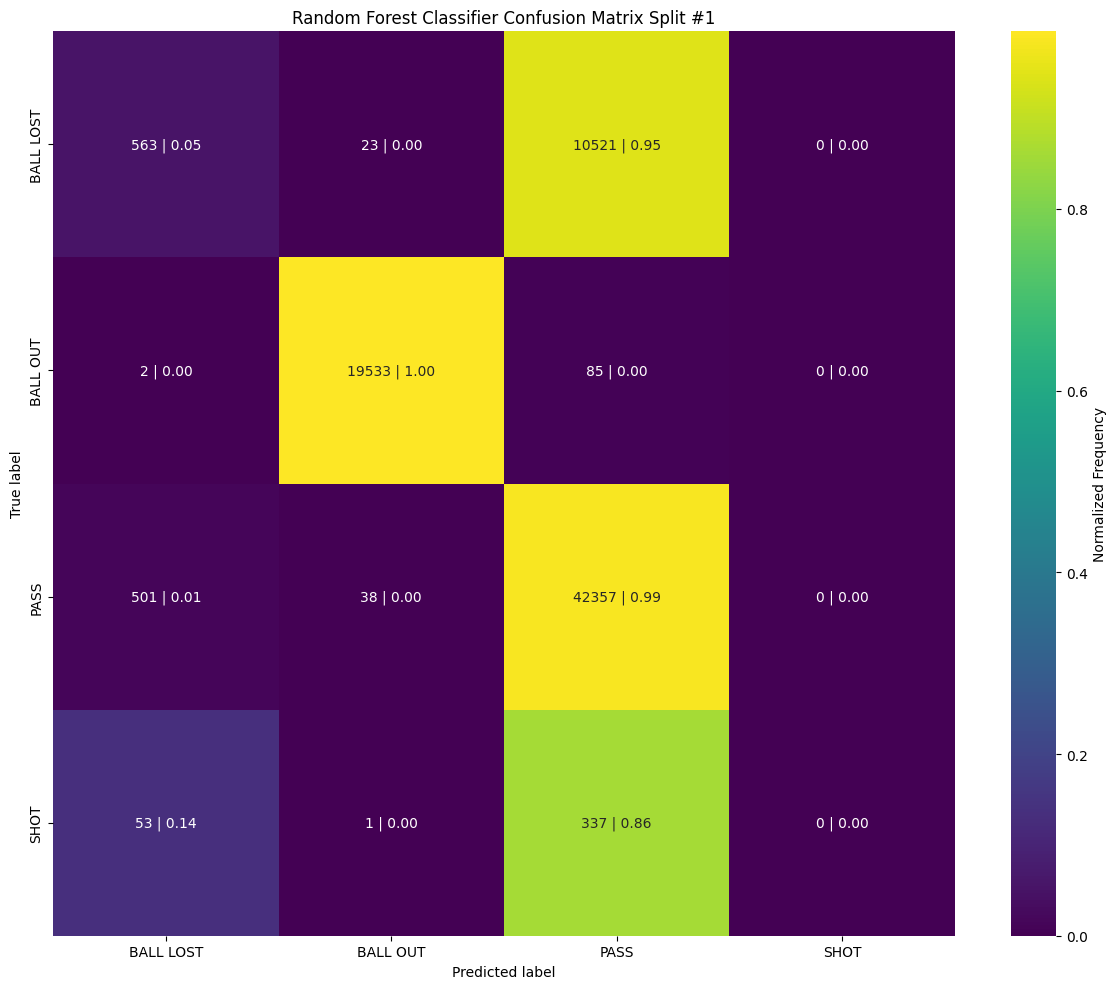

Random forest classifier training accuracy: 97.16%
Random forest classifier testing accuracy: 84.38%

Random forest classifier testing precision: 80.03%
Random forest classifier testing recall: 84.38%
Random forest classifier testing f1: 78.83%




In [67]:
# 93 with negative direction
# for i in range(len(scaled["X_train"])):
for name, model in models.items():
    # X_train_scaled = scaled["X_train"][0]
    # X_test_scaled = scaled["X_test"][0]
    # y_train = scaled["y_train"][0]
    # y_test = scaled["y_test"][0]

    model.fit(X, y)
    y_train_pred = model.predict(X)
    y_pred = model.predict(X_3_scaled)    
    labels = np.unique(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'])
    
    _ = plot_confusion_matrix(y_train=y, y_train_pred=y_train_pred, y_test=y_3, y_pred=y_pred, labels=labels, split=0, model_name=name)
    
    # print("\n")